### Multi Objective Optimization with Credit Risk Analysis
Here we will optimize our AI model for multiple objectives - Performance with Area Under Curve (AUC), and Fairness with Statistical Disparity (SD)

In [1]:
%%capture
#Cell magic to hide outputs 

#Install dependencies
from io import StringIO
import os
import time
import sys
import IPython
from time import gmtime, strftime

import boto3
import numpy as np
import pandas as pd
import urllib

import sagemaker
from sagemaker.s3 import S3Uploader
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost import XGBoost
from sagemaker.s3 import S3Downloader
from sagemaker.s3 import S3Uploader
from sagemaker import Session
from sagemaker import get_execution_role
from sagemaker.xgboost import XGBoostModel
from sagemaker.sklearn import SKLearnModel
from sagemaker.pipeline import PipelineModel
from sagemaker.inputs import TrainingInput


session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/sagemaker-amt-credit-risk-model"
region = session.boto_region_name

# Define IAM role
role = get_execution_role()

In [2]:
# !pygmentize processing/preprocessor.py

## Train XGBoost Model
In this step, we will train an XGBoost model on the preprocessed data. We will use our own training script with the built-in XGBoost container provided by SageMaker.

Alternatively, for your own use case, you can also bring your own model (trained elsewhere) to SageMaker for processing with SageMaker Clarify


### Set up XGBoost Estimator

Next, let us set up:    
 1. Pre-defined values for Hyperparameters for XGBoost algorithm
 1. XGBoost Estimator for SageMaker

    

In [3]:
hyperparameters = {
    "max_depth": "5",
    "eta": "0.1",
    "gamma": "4",
    "min_child_weight": "6",
    "silent": "1",
    "objective": "binary:logistic",
    "num_round": "100",
    "subsample": "0.8",
    "eval_metric": "auc",
    "early_stopping_rounds": "20",
    "output_data_dir": "/opt/ml/output/data/",
}

entry_point = "train_xg_amt_multi.py"
source_dir = "training/"
output_path = "s3://{0}/{1}/{2}".format(bucket, prefix, "xgb_model")
code_location = "s3://{0}/{1}/code".format(bucket, prefix)

estimator = XGBoost(
    entry_point=entry_point,
    source_dir=source_dir,
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    instance_type="ml.c5.xlarge",
    instance_count=1,
    framework_version="0.90-2",
    py_version="py3",
    role=role,
)

### SageMaker AMT (HPO)

Now it's time to run the HPO job to train and find the best model 

#### NOTE: THIS CELL WILL RUN FOR APPROX. 5-8 MINUTES! PLEASE BE PATIENT.

In [4]:
%store -r train_data_path
%store -r val_data_path
%store -r model_path

In [5]:
# Automatic Model Tuning (HPO)

# output_data_dir = 's3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/output/'

from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta': ContinuousParameter(1e-3, 1, 'Logarithmic'),
                        'min_child_weight': ContinuousParameter(1e-6, 10, 'Logarithmic'),
                        'gamma': ContinuousParameter(1e-6, 10, 'Logarithmic'),
                        'max_depth': IntegerParameter(2, 10, 'Linear')}

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=100, # 100
                            max_parallel_jobs=10, #16
                           )

tuning_job_name = "xgb-tuner-{}".format(strftime("%d-%H-%M-%S", gmtime()))

# inputs = {'train': train_data_path, 'validation': val_data_path, 'output_data_dir': output_data_dir}

inputs = {'train': train_data_path, 'validation': val_data_path}

tuner.fit(inputs, job_name=tuning_job_name)

tuner.wait()

tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...................................................................................................................................................!
!


In [6]:
tuner.best_training_job()

'xgb-tuner-27-00-32-14-052-be514283'

In [7]:
xgboost_model_data = (
    "s3://{}/{}/{}/{}".format(bucket, prefix, "xgb_model", tuner.best_training_job()) + "/output/model.tar.gz"
)

In [8]:
xgboost_inference_code_location = "s3://{}/{}/{}/code".format(bucket, prefix, "xgb_model")

xgboost_model = XGBoostModel(
    name="xgb-model-{0}".format(str(int(time.time()))),
    model_data=xgboost_model_data,
    entry_point="inference.py",
    source_dir="inference/xgboost/",
    code_location=xgboost_inference_code_location,
    framework_version="0.90-2",
    py_version="py3",
    role=role,
    sagemaker_session=session,
)

In [9]:
from datetime import datetime

endpoint_name = f"MULTI-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", endpoint_name)

EndpointName = MULTI-2023-01-27-0044


In [10]:
#Create Endpoint Instance

#Instance Count
initial_instance_count=1 # Example
#instance Type
instance_type='ml.m5.large' # Example

FinalModel = xgboost_model.deploy(
    initial_instance_count=initial_instance_count,
    instance_type=instance_type,
    endpoint_name=endpoint_name
)

-----!

In [11]:
#Validation
n = val_data_path+"val_features.csv"
test_dataset = S3Downloader.read_file(n)
n

's3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/preprocessed/val/val_features.csv'

In [12]:
print(len(test_dataset))
test_dataset = test_dataset.split("\n")
print(len(test_dataset))

44157
221


In [13]:
for i in range(len(test_dataset)-1):
    test_dataset[i] = np.fromstring(test_dataset[i], dtype=float, sep=',')

In [14]:
#Set up predictor 
from sagemaker.serializers import CSVSerializer
predictor = sagemaker.predictor.Predictor(
    endpoint_name,
    session,
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

In [15]:
#Make Predictions on the test dataset
Multi_Optimized_Predictions = []
for i in range(len(test_dataset)-1):
    Multi_Optimized_Predictions.append(predictor.predict(test_dataset[i]))

In [16]:
#See first 3 predictions and how they look. We have the double brackets meaning each element is a 3 dimensional element, we will make them a single dimension in the next cell 
print(Multi_Optimized_Predictions[0])
print(Multi_Optimized_Predictions[1])
print(Multi_Optimized_Predictions[2])

[['0.9327612']]
[['0.86414945']]
[['0.9440027']]


In [17]:
#Turn each item into a single dimension element in the list  
Predictions = []
for i in range(len(Multi_Optimized_Predictions)):
    Predictions.append(Multi_Optimized_Predictions[i][0][0])

In [18]:
#Look at first 3 processed predictions. They are now i nthe format we want
print(Predictions[0])
print(Predictions[1])
print(Predictions[2])

0.9327612
0.86414945
0.9440027


In [19]:
#Each prediction value is between 0 - 1. But the target variable "Credit Risk" is either bad (0) or good (1) there for we will round up/down to ensure every value is either 0 or 1
for i in range(len(Predictions)):
    if (float(Predictions[i]) >= float(0.5)):
        Predictions[i] = 1 
    elif (float(Predictions[i]) < float(0.5)):
        Predictions[i] = 0

In [20]:
#Look at first 3 predictions now to confirm we will be able to see they are either 0 or 1 
print(Predictions[0])
print(Predictions[1])
print(Predictions[2])

1
1
1


In [21]:
#Check how many predictions were 0 (Bad Credit) and 1(Good Credit)
print(Predictions.count(0))
print(Predictions.count(1))

71
149


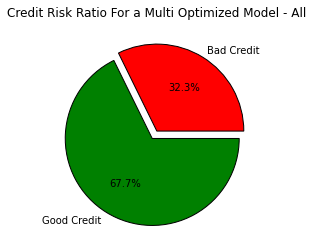

In [22]:
#Graph the predictions as a pie graph
from matplotlib import pyplot as plt

slices = [Predictions.count(0),Predictions.count(1)]
labels = ['Bad Credit', 'Good Credit']
colors = ['red', 'green']
explode = [0, 0.1]
plt.pie(slices, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title("Credit Risk Ratio For a Multi Optimized Model - All")
plt.show()

In [23]:
#Now let us take a look at Foreign worker predictions only. the last element in the list represents Foreign workers (1 means foreign 2 means non-foreign)
filtered_dataset=[]
for i in range(len(test_dataset)-1):
    if test_dataset[i][-1] == 1:
        filtered_dataset.append(test_dataset[i])
len(filtered_dataset)

36

In [24]:
len(filtered_dataset)

36

In [25]:
#Make Predictions on the test dataset
Multi_F_Predictions = []
for i in range(len(filtered_dataset)):
    Multi_F_Predictions.append(predictor.predict(filtered_dataset[i]))

In [26]:
#Turn each item into a single dimension element in the list  
for i in range(len(Multi_F_Predictions)):
    Multi_F_Predictions[i]=(Multi_F_Predictions[i][0][0])

In [27]:
Multi_F_Predictions

['0.24157475',
 '4.7756188e-05',
 '0.06342731',
 '0.93585235',
 '6.523058e-05',
 '0.5261048',
 '0.7142568',
 '0.014334942',
 '0.017389935',
 '9.352473e-05',
 '0.6630546',
 '0.4402347',
 '0.044109173',
 '0.13703965',
 '0.13513479',
 '0.09022986',
 '0.27975675',
 '0.7313284',
 '0.8185003',
 '0.123835415',
 '0.042360604',
 '0.000822239',
 '0.0046404405',
 '0.03956926',
 '0.932917',
 '0.76213884',
 '0.00038311264',
 '0.12971416',
 '0.90214473',
 '0.0013121088',
 '0.0013635819',
 '0.8794973',
 '0.026009575',
 '0.08722933',
 '0.85275924',
 '0.0009555685']

In [28]:
#Each prediction value is between 0 - 1. But the target variable "Credit Risk" is either bad (0) or good (1) there for we will round up/down to ensure every value is either 0 or 1
for i in range(len(Multi_F_Predictions)):
    if (float(Multi_F_Predictions[i]) >= float(0.5)):
        Multi_F_Predictions[i] = 1 
    elif (float(Multi_F_Predictions[i]) < float(0.5)):
        Multi_F_Predictions[i] = 0

In [29]:
#Check how many predictions were 0 (Bad Credit) and 1(Good Credit)
print(Multi_F_Predictions.count(0))
print(Multi_F_Predictions.count(1))

25
11


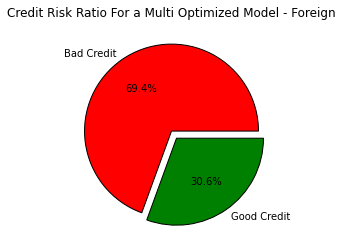

In [30]:
#Pie Graph
slices = [Multi_F_Predictions.count(0),Multi_F_Predictions.count(1)]
labels = ['Bad Credit', 'Good Credit']
colors = ['red', 'green']
explode = [0, 0.1]
plt.pie(slices, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title("Credit Risk Ratio For a Multi Optimized Model - Foreign")
plt.show()

46
138


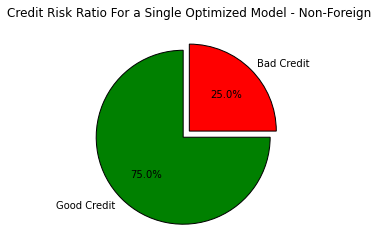

In [31]:
#TESTING - Non Foreign Workers
filtered_dataset=[]
for i in range(len(test_dataset)-1):
    if test_dataset[i][-1] == 2:
        filtered_dataset.append(test_dataset[i])
len(filtered_dataset)

Single_F_Predictions = []
for i in range(len(filtered_dataset)):
    Single_F_Predictions.append(predictor.predict(filtered_dataset[i]))
    
for i in range(len(Single_F_Predictions)):
    Single_F_Predictions[i]=(Single_F_Predictions[i][0][0])
    
for i in range(len(Single_F_Predictions)):
    if (float(Single_F_Predictions[i]) >= float(0.5)):
        Single_F_Predictions[i] = 1 
    elif (float(Single_F_Predictions[i]) < float(0.5)):
        Single_F_Predictions[i] = 0

print(Single_F_Predictions.count(0))
print(Single_F_Predictions.count(1))

#Pie Graph
slices = [Single_F_Predictions.count(0),Single_F_Predictions.count(1)]
labels = ['Bad Credit', 'Good Credit']
colors = ['red', 'green']
explode = [0, 0.1]
plt.pie(slices, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title("Credit Risk Ratio For a Single Optimized Model - Non-Foreign")
plt.show()

In [32]:
# Generate Pareto Frontier 
def get_pareto_frontier(Xs, Ys, maxX=False, maxY=True):
    """plot Pareto front

    in AMT this is impossible, since there is only one merged metric, But I
    show here just from a scientific viewpoint

    """
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)

    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    return pf_X, pf_Y

In [33]:
# S3 bucket's tmp folder is populated by results from training jobs run by HPO (Automatic Model Tuning)
import boto3
import pandas as pd
import io

s3 = boto3.resource('s3')
bucket = s3.Bucket(session.default_bucket())
prefix_objs = bucket.objects.filter(Prefix="sagemaker/sagemaker-amt-credit-risk-model/data/output/tmp/")
objects = iter(prefix_objs)
next(objects)

s3.ObjectSummary(bucket_name='sagemaker-us-east-2-921553072635', key='sagemaker/sagemaker-amt-credit-risk-model/data/output/tmp/02397abf-output.txt')

In [34]:
prefix_df = []

from io import BytesIO

for obj in objects:
    key = obj.key
    body = obj.get()['Body'].read()
    tmp = str(body, 'UTF-8').strip()
    prefix_df.append(tmp)
    
# prefix_df

In [35]:
df = pd.DataFrame(prefix_df)
df['models_list'] = df[0].str.split(',')
df_models = pd.DataFrame(df['models_list'].tolist()).fillna('').add_prefix('model_')
df_models.rename(columns={'model_0': 'sd', 'model_1': 'auc'}, inplace=True)
df_models.to_csv('sd_auc_pareto_frontier.csv', index=False, header=True)
sd_str_list = df_models.iloc[:, 0].tolist()
sd_float_list = [float(x) for x in sd_str_list]
auc_str_list = df_models.iloc[:, -1].tolist()
auc_float_list = [float(x) for x in auc_str_list]

In [36]:
pf_X, pf_Y = get_pareto_frontier(Xs=sd_float_list,Ys=auc_float_list)

In [37]:
#Eliminate all 0's in pf_X and corresponding points in pf_Y 
i = 0 
while i < len(pf_X):
    if pf_X[i] != 0:
        i += 1
    else:
        del(pf_X[i])
        del(pf_Y[i])
#Eliminate all 0's in sd_float_list and corresponding points in auc_float_listY 
i = 0 
while i < len(sd_float_list):
    if sd_float_list[i] != 0:
        i += 1
    else:
        del(sd_float_list[i])
        del(auc_float_list[i])

Baseline Statistical Disparity:  0.75
Baseline Area Under Curve:  0.74 

Optimized Statistical Disparity:  0.43
Optimized Area Under Curve:  0.72 



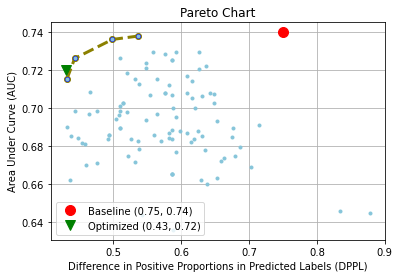

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt

#Worst one wihtout optimization - You can get thess baseline value from the values you found in Notebook 2
baseline_sd = 0.75 
baseline_auc = 0.74

#REAL ONE After optimization - follow steps from Notebook 2 for the training job created in this notebook to find these values. 
optimized_sd = 0.43
optimized_auc = 0.72
#combined = 0.75
ax = plt.subplots()
#Add grid 
plt.grid()

#Graph pareto front chart 
plt.title("Pareto Chart")
plt.xlabel("Difference in Positive Proportions in Predicted Labels (DPPL)")
plt.ylabel("Area Under Curve (AUC)")

#Plot co ordinates 
plt.plot(pf_X, pf_Y, linestyle='--', linewidth=3, marker='o', c='#8B8000', mfc='b')
#Plot additional points
plt.plot(sd_float_list, auc_float_list, linestyle='None', marker='o', markersize=3, color='#86C5DA')
#Show baseline SD & AUC 
plt.plot(baseline_sd, baseline_auc, "ro", markersize='10', label=("Baseline ("+str(baseline_sd)+", "+str(baseline_auc)+")"))
#Show optimized SD & AUC  
plt.plot(optimized_sd, optimized_auc, "gv", markersize='10', label=("Optimized ("+str(optimized_sd)+", "+str(optimized_auc)+")"))
#Legend
plt.legend(loc="lower left")

#Print Baseline Values 
print("Baseline Statistical Disparity: ",baseline_sd)
print("Baseline Area Under Curve: ",baseline_auc,"\n")

#Print Optimized Values
print("Optimized Statistical Disparity: ",optimized_sd)
print("Optimized Area Under Curve: ",optimized_auc,"\n")

### The cell below provides a range of visualization for the tuning job above. This visualization and its libraries were provided by the following repo:

https://github.com/aws-samples/amazon-sagemaker-amt-visualize/blob/main/1_tuning_of_builtin_xgboost.ipynb 

In [39]:
#!pip install altair
from amtviz import visualize_tuning_job
visualize_tuning_job(tuner, trials_only=True)

Setting altair renderer to default.
Tuning job xgb-tuner-27-00-32-14     status: Completed

Number of training jobs with valid objective: 100
Lowest: 0.5139889717102051 Highest 0.6838629841804504


,eta,gamma,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,validation:auc
48,0.548612,0.012421,4.0,0.000066,xgb-tuner-27-00-32-14-052-be514283,Completed,2023-01-27 00:39:38+00:00,2023-01-27 00:40:47+00:00,69.0,xgb-tuner-27-00-32-14,0.683863
68,0.544451,0.000904,4.0,0.000078,xgb-tuner-27-00-32-14-032-c6499eb4,Completed,2023-01-27 00:37:02+00:00,2023-01-27 00:37:40+00:00,38.0,xgb-tuner-27-00-32-14,0.678610
71,0.643851,0.000088,4.0,0.000003,xgb-tuner-27-00-32-14-029-43d2f514,Completed,2023-01-27 00:36:36+00:00,2023-01-27 00:37:08+00:00,32.0,xgb-tuner-27-00-32-14,0.677474
86,0.648377,0.000098,4.0,0.000018,xgb-tuner-27-00-32-14-014-7c090c65,Completed,2023-01-27 00:35:18+00:00,2023-01-27 00:35:50+00:00,32.0,xgb-tuner-27-00-32-14,0.669266
81,0.718554,0.054962,4.0,0.000013,xgb-tuner-27-00-32-14-019-b6885f1d,Completed,2023-01-27 00:35:35+00:00,2023-01-27 00:36:12+00:00,37.0,xgb-tuner-27-00-32-14,0.667242
35,0.524844,0.066738,3.0,0.000008,xgb-tuner-27-00-32-14-065-f1f06d11,Completed,2023-01-27 00:40:21+00:00,2023-01-27 00:40:58+00:00,37.0,xgb-tuner-27-00-32-14,0.665081
87,0.611708,0.000091,4.0,0.004199,xgb-tuner-27-00-32-14-013-e0d8f46a,Completed,2023-01-27 00:35:16+00:00,2023-01-27 00:35:53+00:00,37.0,xgb-tuner-27-00-32-14,0.663159
44,0.730583,0.002627,4.0,0.000487,xgb-tuner-27-00-32-14-056-250a354c,Completed,2023-01-27 00:39:24+00:00,2023-01-27 00:40:01+00:00,37.0,xgb-tuner-27-00-32-14,0.659589
88,0.474216,0.000016,3.0,0.000453,xgb-tuner-27-00-32-14-012-33b1a582,Completed,2023-01-27 00:35:14+00:00,2023-01-27 00:35:51+00:00,37.0,xgb-tuner-27-00-32-14,0.658692
40,0.498717,0.000230,5.0,0.000013,xgb-tuner-27-00-32-14-060-c903e078,Completed,2023-01-27 00:39:45+00:00,2023-01-27 00:40:22+00:00,37.0,xgb-tuner-27-00-32-14,0.657385


alt.VConcatChart(...)

### Clean-up

Remove any resources to save on AWS cost.

In [40]:
#CLEAN UP - Uncomment code in this cell to Spin Down Endpoint

# Create a low-level SageMaker service client.
sagemaker_client = boto3.client('sagemaker', region_name="us-east-2")

# Delete endpoint
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

#Clean-up temporary files in s3 bucket.Removing these temp files will impact re-creating the 'pareto frontier' chart

import boto3
s3_client = boto3.client('s3')
session = Session()
s3_bucket = session.default_bucket()
s3_bucket_prefix = "sagemaker/sagemaker-amt-credit-risk-model/data/output/tmp/"
response = s3_client.list_objects_v2(Bucket=s3_bucket, Prefix=s3_bucket_prefix)
for object in response['Contents']:
    s3_client.delete_object(Bucket=s3_bucket, Key=object['Key'])